## Analysis AirBnb listings in New York

by Julie Olin, Mik Lokdam and Julian Roin Skovhus

### Preface
This is the detailed notebook including all the code, analysis, results and related discussion done in this project. For a short, visual presentation, visit the [website](https://julieolin.github.io/week8/).

#### Preamble

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import io
from PIL import Image
import seaborn as sns
import json
import branca.colormap as cm
import geopandas as gpd
import warnings
from bokeh.io import output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, ranges, Legend
from bokeh.palettes import Category20
output_notebook()
import math

warnings.filterwarnings('ignore')
colors = sns.color_palette("plasma")

Loading BokehJS ...

### 1. Motivation

In this project our study area is confined to New York, the Big Apple, the City that Never Sleeps. By looking at the 4 different datasets (summarized in the table below), we wish to create an interactive guide that can help tourists to choose where to stay depending on their needs and wants. 

Besides information on the AirbBnb listings, we also include information on crime, noise complaints and cafes/restaurants. One could include many other data sets to describe a city, but we considered these to be key contributors to the niceness of a neighborhood. Additionally, the included data set needed to have spatial dimensions, which limited the amount of useable data sets significantly. 

With over AirBnB 48.000 listings in New York, there are plenty of places to choose from and given the fact that there are more than 19 mio. residents in a fairly small area, the diversity is high and districts have their own 'spark'. To help tourists in choosing the right district without having to read a myriad of blogs, we have created this visual guide based on explorative and explanative data analysis.

We choose to combine these 4 datasets as each have features that we believe influence a tourists desire to live in a neighbourhood. The features and some high level information for each data set can be seen below:


| Dataset                	| Function                                                                      	| Features                        	| Size   	| Year    	|
|------------------------	|-------------------------------------------------------------------------------	|---------------------------------	|--------	|---------	|
| AirBnBs                	| Assess districts based on the availability, busyness and quality of  AirBnBs  	| Location Price Reviews Time     	| 7 MB   	| 2019    	|
| Crime data             	| Assess the safety of districts                                                	| Type Time Location              	| 2 GB   	| 2006-17 	|
| Parties                	| Assess the noise                                                              	| LocationDate Size of complaints 	| 53 MB  	| 2016    	|
| Restaurant inspections 	| Assess the possibility for eating out & quality / sanity                      	| Location DateInspection grade   	| 139 MB 	| 2018    	|

Through extracting the relevant features from the dataset, we will look at:

1) the availability, popularity and quality of AirBnBs
The AirBnB dataset has features that explains the prices, number of reviews and location of AirBnBs. We assume price differences and location is a good indicator for assessing informations of NYC.

2) the safety
The Crime data has features that explains the type, date and location of reported crimes. We assume this is a good indicator for assessing the crime level in the area and subsequently the level of safeness 

3) the noise
The Party dataset explains the location, date and number of reported noise complaints. We assume this is a good indicator for assessing the quietness / noise in the area.

4) quantity and quality of food / sanity
The Restaurant Inspection dataset explains the location, date and inspection grade of restaurants. We assume this is a good indicator for the amount and the quality of the restaurants in the area.

#### Criticism:
Years doesn’t match



## 2. Basic stats

In this section we will perform an exploratory data analysis of the AirBnb data set. We will mainly focus on investigating price, location and hosts. Towards the end, we will introduce the other data sets.

For now, we will only load the AirBnb data set and an shp-file including the districts of Manhattan. 

In [2]:
df_bnb = pd.read_csv('AB_NYC_2019.csv')
fname = 'manhat_last.shp'
nil = gpd.read_file(fname)

#### 2a) Preprocessing and data cleansing

Lets start by viewing the first few rows of the data set.

In [3]:
df_bnb.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


We can see that if no reviews of a listing have been given the attributes 'last_review' and 'review_per_month' are set to NaN. We will simply set them to zero instead.  

In [4]:
df_bnb.fillna({'reviews_per_month':0}, inplace=True)
df_bnb.fillna({'last_review':0}, inplace=True)

Lets try to identify other nan values within the data.

In [5]:
df_bnb.isna().sum()

id                                 0
name                              16
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
last_review                        0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

We see that it is only the name of AirBnb listing and the name which are missing. None are essential for our analysis, so we will keep them as nans. 

#### 2b) Dataset stats

Initially, we look at the five large boroughs of New York. Lets see how the AirBnbs are distributed across the boroughs.

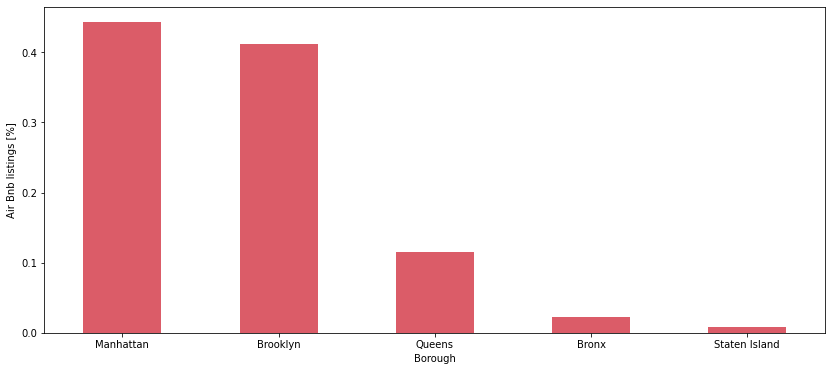

In [6]:
## Amount across boroughs
df_borough_count = df_bnb.groupby('neighbourhood_group').count()
df_borough_count['id'] = df_borough_count['id']/len(df_bnb)
fig, ax = plt.subplots(figsize=(14,6))
(df_borough_count.sort_values(by = 'id', ascending = False))['id'].plot(kind = 'bar', ax = ax, rot = 0, color=colors[3])
ax.set_xlabel('Borough')
ax.set_ylabel('Air Bnb listings [%]')
plt.show()

Majority of listings are in Manhattan and Brooklyn. Let us take a quick loot at the price distributions across the boroughs. To this end, we will use a violin plot which is very similar to a boxplot. However, as the violin plot also includes a probability density at different prices. This helps us identify the several peaks in prices that we expect.

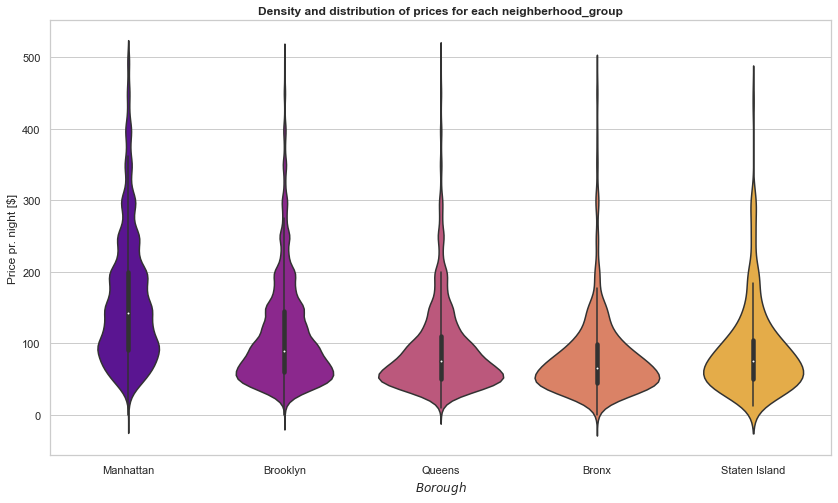

In [54]:
## Price across boroughs
fig, ax = plt.subplots(figsize=(14, 8))
sns.set_theme(style="whitegrid")
v2=sns.violinplot(ax = ax, data=df_bnb[df_bnb['price']<500], x='neighbourhood_group', y='price', 
                  palette = 'plasma', order=[ "Manhattan", "Brooklyn", "Queens", 'Bronx', 'Staten Island'])
v2.set_title('Density and distribution of prices for each neighberhood_group',  fontweight='bold')
ax.set(xlabel='$Borough$', ylabel='Price pr. night [$]')
plt.show()

It appears that Manhattan has a higher median price of around 75\\$ than the other five boroughs. This was expected as Manhattan is centrally located and known for it is expensive housing prices which would affect the rental price as well. For Brooklyn and Manhattan we can identify the small bulges as integer prices (100\\$, 150\\$, 200\\$ etc.). We have only considered the rentals below 500\\$ as there are extreme expensive rentals, which would make the figure hard to read.

We focus the remainder of the analysis on Manhattan. This is because it is the most famous borough in New York and we want the analysis to help people who want the real New York-experience. It will also help us do more detailed analysis on specific neighborhoods. The downside is of course loss of data, but we still have around 22.000 rows.  

Let us consider the distribution of Airbnbns acorss the neighborhoods in Manhattan

In [8]:
## Basic stats
df_manhattan = df_bnb[df_bnb['neighbourhood_group'] == 'Manhattan']
df_manhattan_count = df_manhattan.groupby('neighbourhood').count()

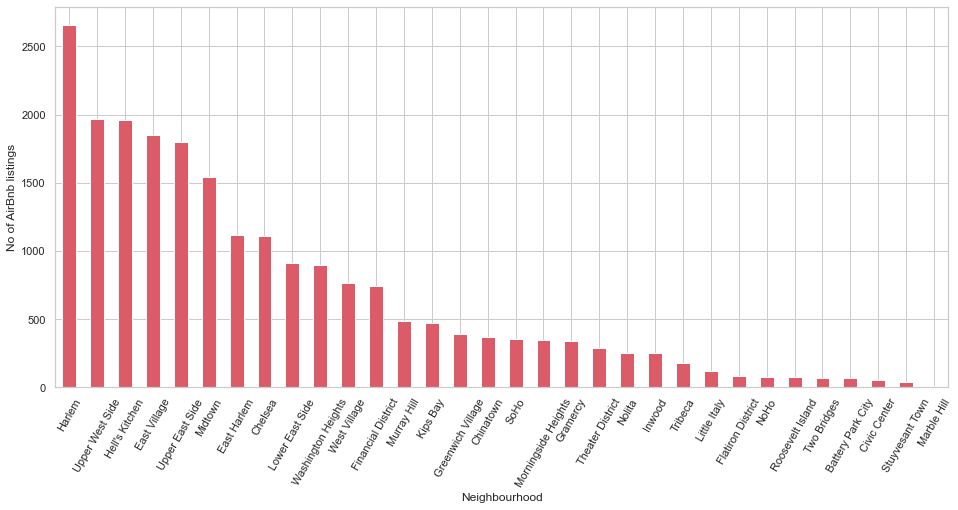

In [9]:
fig, ax = plt.subplots(figsize=(16,7))
(df_manhattan_count.sort_values(by = 'id', ascending = False))['id'].plot(kind = 'bar', ax = ax, rot = 60, color = colors[3])
ax.set(xlabel='Neighbourhood', ylabel='No of AirBnb listings')
plt.show()

Harlem has by the most listings followed by Upper West Side and Hell's Kitchen. It appears that Stuyvesant Town and Marble Hill have no listings. However, they do have 37 and 12 respectively. 

Lets take a look at the price distribution across all neighbourhoods

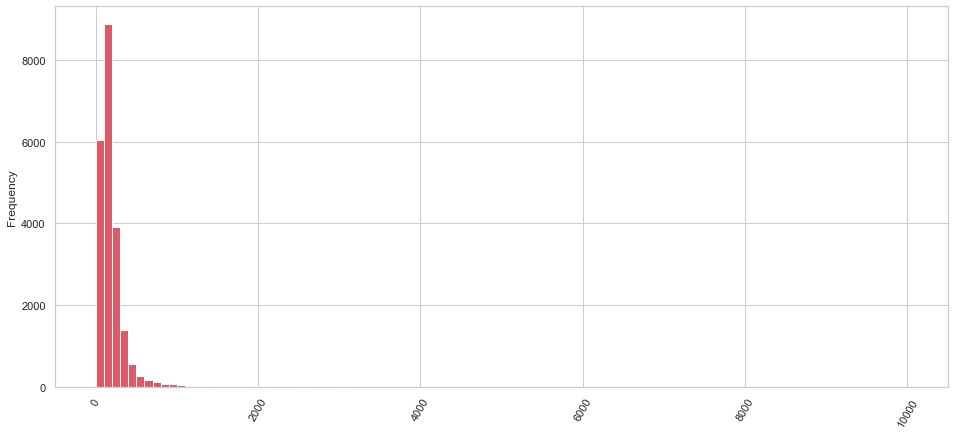

In [10]:
fig, ax = plt.subplots(figsize=(16,7))
(df_manhattan['price'].plot(kind = 'hist', ax = ax, rot = 60, color = colors[3], bins = 100))
plt.show()

It appears that the histogram is "drawn out" by high prices at around 10000$ pr. night! Lets inspect the most expensive AirBnb listings in Manhattan.

In [11]:
df_manhattan[df_manhattan['price']>5000]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
3537,2110145,UWS 1BR w/backyard + block from CP,2151325,Jay And Liz,Manhattan,Upper West Side,40.77782,-73.97848,Entire home/apt,6000,14,17,2015-02-17,0.27,1,359
3720,2243699,"SuperBowl Penthouse Loft 3,000 sqft",1483320,Omri,Manhattan,Little Italy,40.71895,-73.99793,Entire home/apt,5250,1,0,0,0.00,1,0
6530,4737930,Spanish Harlem Apt,1235070,Olson,Manhattan,East Harlem,40.79264,-73.93898,Entire home/apt,9999,5,1,2015-01-02,0.02,1,0
12342,9528920,"Quiet, Clean, Lit @ LES & Chinatown",3906464,Amy,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,2016-01-01,0.14,1,83
15560,12520066,Luxury townhouse Greenwich Village,66240032,Linda,Manhattan,Greenwich Village,40.73046,-73.99562,Entire home/apt,6000,1,0,0,0.00,1,0
29238,22436899,1-BR Lincoln Center,72390391,Jelena,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,0,0.00,1,83
29662,22779726,East 72nd Townhouse by (Hidden by Airbnb),156158778,Sally,Manhattan,Upper East Side,40.76824,-73.95989,Entire home/apt,7703,1,0,0,0.00,12,146
29664,22780103,Park Avenue Mansion by (Hidden by Airbnb),156158778,Sally,Manhattan,Upper East Side,40.78517,-73.95270,Entire home/apt,6419,1,0,0,0.00,12,45
30268,23377410,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,18128455,Rum,Manhattan,Tribeca,40.72197,-74.00633,Entire home/apt,8500,30,2,2018-09-18,0.18,1,251
37194,29547314,Apartment New York \nHell’s Kitchens,35303743,Patricia,Manhattan,Upper West Side,40.76835,-73.98367,Private room,6500,30,0,0,0.00,1,97


Words as luxury, spacious, yacht, penthouse and >3000sq.ft all appear in the name of the apartments which maybe justifies the astronomical prices. The private rooms in Lower East Side and Upper West Side and aparatmens with a price pr. night of 9999\\$ are almost certainly mistakes by the host, but we cannot know for sure. Hence we will keep them in the data set. Although the most expensive apartments are interesting, we get more information from the histogram by investigating apartments below a threshold as for the violin plots earlier.

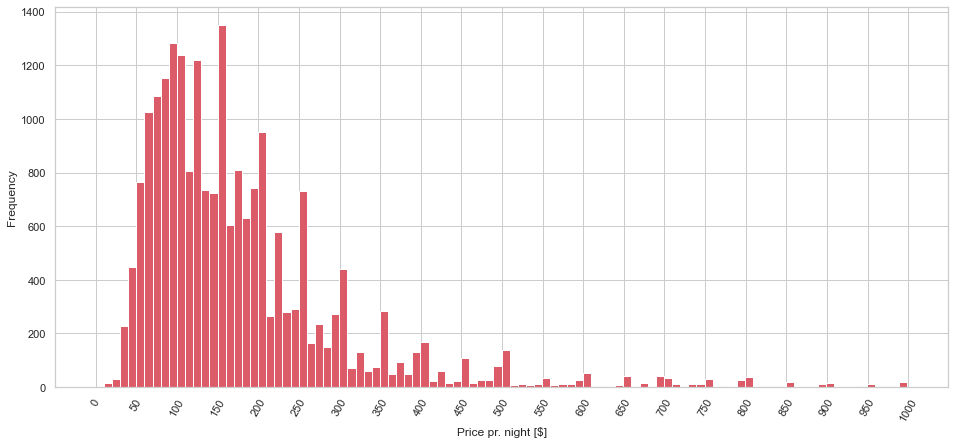

In [12]:
fig, ax = plt.subplots(figsize=(16,7))
(df_manhattan[df_manhattan['price']<1000]['price'].plot(kind = 'hist', ax = ax, rot = 60, color = colors[3], bins = 100))
ax.set_xticks(np.arange(0,1001,50))
ax.set_xlabel('Price pr. night [$]')
plt.show()

We see that the shape looks to be a right skewed normal distribution with most listings with a price of 150\\$ pr. night. When looking at mean price pr. night across neighborhoods, we look at rentals below 1000\\$ pr. night. The reason for this is that 1) the few, very expensive apartments scew the prices, especially in the neighborhoods with few listings 2) this an analysis for the people, not the filthy rich. The downside is loss of data, but it is only around 172 listings. 

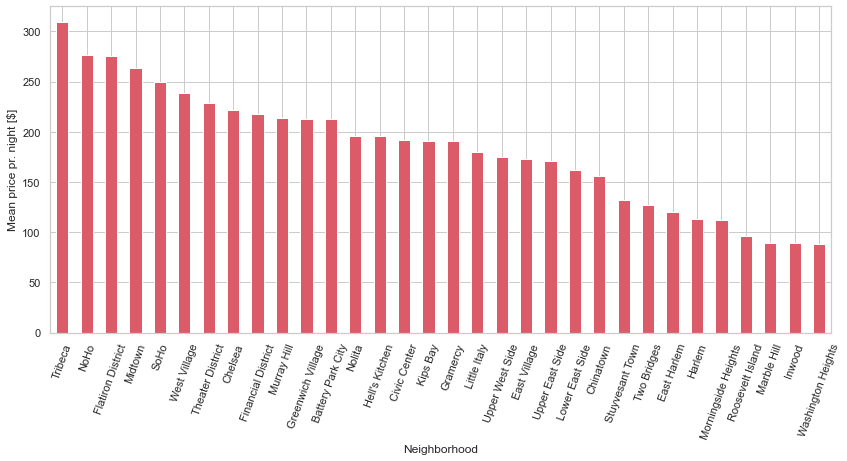

In [13]:
df_manhattan_price = df_manhattan[df_manhattan['price']<1000].groupby('neighbourhood').mean()
fig, ax = plt.subplots(figsize=(14,6))
(df_manhattan_price.sort_values(by = 'price', ascending = False))['price'].plot(kind = 'bar', ax = ax, rot = 70, color = colors[3])
ax.set_ylabel('Mean price pr. night [$]')
ax.set_xlabel('Neighborhood')
plt.show()

We see that Tribeca is quite in front in mean price followed by NoHo, Flatiron District and Midtown. Later we will look into the spatial influence on the price, but first will look into rental types, availability, reviews and introduce the other data sets that we will use for the analysis. 




We study the avg. price pr. night across the three different room types in an interactive plot with Bokeh. We first use group by on 'room_type' and 'neighborhood' and then we convert the dataframe into the required format for Bokeh. Some neighborhoods have no shared rooms, hence we have to manually add a row with this information.

In [14]:
## Computing the avg. price pr. room type for all neighborhoods
df_manhattan_avgprice = df_manhattan[['neighbourhood', 'room_type','price']]
df_add = pd.DataFrame([['Civic center', 'Shared room', 0], ['Flatiron District', 'Shared room', 0],['Marble Hill', 'Shared room', 0], 
                       ['NoHo', 'Shared room', 0], ['Tribeca', 'Shared room', 0], ['Two Bridges', 'Shared room', 0]], columns= ['neighbourhood', 'room_type', 'price'])

df_manhattan_avgprice = df_manhattan_avgprice.append(df_add, ignore_index=True)
df_manhattan_avgprice = df_manhattan_avgprice.groupby(['room_type', 'neighbourhood']).mean()

In [15]:
## Reformatting
df_plot = pd.DataFrame()
room_type = ['Entire home/apt', 'Private room', 'Shared room']

for i in room_type:
    df_plot[i] = np.ravel(df_manhattan_avgprice.loc[i].values)
    
df_plot['district'] = ['Battery Park City', 'Chelsea', 'Chinatown', 'Civic Center',
       'East Harlem', 'East Village', 'Financial District',
       'Flatiron District', 'Gramercy', 'Greenwich Village', 'Harlem',
       "Hell's Kitchen", 'Inwood', 'Kips Bay', 'Little Italy',
       'Lower East Side', 'Marble Hill', 'Midtown', 'Morningside Heights',
       'Murray Hill', 'NoHo', 'Nolita', 'Roosevelt Island', 'SoHo',
       'Stuyvesant Town', 'Theater District', 'Tribeca', 'Two Bridges',
       'Upper East Side', 'Upper West Side', 'Washington Heights',
       'West Village']

The cell below produces the plot. We will not split it furhter for additional explanation.

In [16]:
cols = ['steelblue','lightcoral', 'darkseagreen']

room_type = ['Entire home/apt', 'Private room', 'Shared room']
source = ColumnDataSource(df_plot)

dist = (np.array(['Battery Park City', 'Chelsea', 'Chinatown', 'Civic Center',
       'East Harlem', 'East Village', 'Financial District',
       'Flatiron District', 'Gramercy', 'Greenwich Village', 'Harlem',
       "Hell's Kitchen", 'Inwood', 'Kips Bay', 'Little Italy',
       'Lower East Side', 'Marble Hill', 'Midtown', 'Morningside Heights',
       'Murray Hill', 'NoHo', 'Nolita', 'Roosevelt Island', 'SoHo',
       'Stuyvesant Town', 'Theater District', 'Tribeca', 'Two Bridges',
       'Upper East Side', 'Upper West Side', 'Washington Heights',
       'West Village'])).tolist()

p = figure(plot_height=450, plot_width=900, x_range = dist, title = 'Avg. price for room types for all neighbourhoods')
p.xaxis.axis_label = "Neighbourhood"
p.yaxis.axis_label = "Avg. price pr. night"

bar ={}
for indx, i , color in zip(np.arange(len(room_type)), room_type, cols):
    bar[i] = p.vbar(x='district', top=i, source=source,  
                    muted_alpha=0.02, width = 0.5, alpha = 0.7, color = color)
    
items = []
for indx, i in enumerate(room_type):
    items.append((i, [bar[i]]))


legend = Legend(items=items, location=(5, 0))  
p.add_layout(legend, 'right')
p.legend.click_policy="mute" 
p.xaxis.major_label_orientation = math.pi/3
show(p)

Interesting points here is that Tribeca still has the most expensive Entire home/apt, but the private rooms of Midtown and West Village are more expensive. With relative few listings in the Financial District the average price of a shared room is almost as much as an entire home/apt. This is unlikely and probably rather due to one a two shared rooms skewing the prices. There is lots of more information - tinker with it yourself! 

As a final step in the the non-spatial exploration of the Airbnb dataset, we will take a look at reviews. Reviews are always a good indicator of an Airbnb and probably one of the first things we look at when we have found a potential vacation home. We will make a boxplot of number of reviews for some of the neighborhoods with most listings.

In [17]:
df_small

NameError: name 'df_small' is not defined

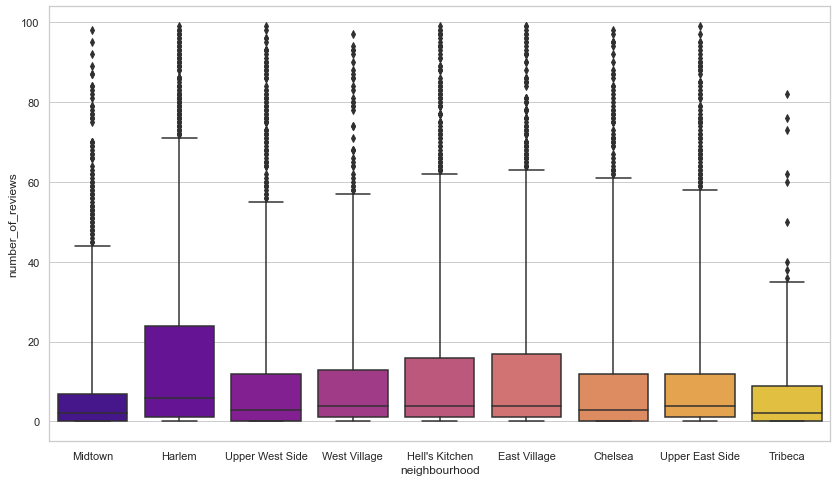

In [18]:
most_listings = ['Harlem', 'Upper West Side', 'Hell\'s Kitchen', 'East Village', 'Upper East Side', 'Chelsea', 'West Village', 'Midtown', 'Tribeca']
df_small = df_manhattan[df_manhattan.neighbourhood.isin(most_listings)]

fig, ax = plt.subplots(figsize=(14, 8))
b2 = sns.boxplot(ax = ax, data = df_small[df_small['number_of_reviews']<100], x="neighbourhood", y="number_of_reviews", 
                 palette = 'plasma', whis=[5, 95])

We have the whiskers to represent the 5% and 95% percentiles meaning that inside the whiskers, 95% of the data lies. While the median is quite close to each other across neighborhoods, we can see a big difference in inner quantiles and 95% quantile. As it is generally good to read reviews before choosing where you want to stay, one can look for hosts in especially Harlem and also East Village/Hells Kitchen as there is a good chance that will have more reviews. Beware that many reviews can also be an indicator that a place is horrible. Keep that in mind and remember to read the reviews!  

Some hosts have several listings which can also. Lets try to see who have the most in Manhattan. They can be a good starting point, if one is in doubt of which AirBnbs are 'safe' to consider. 

In [20]:
top_host=df_manhattan.host_id.value_counts().head(10)
host_df = df_manhattan.set_index('host_id')
top_host_df=pd.DataFrame(top_host)
top_host_count = host_df.loc[top_host.index]
top_host_df['name'] = host_df.loc[top_host.index].host_name.unique()
mean_price = top_host_count.groupby('host_id').mean()
top_host_df['mean_price'] = mean_price['price']
top_host_df = top_host_df.set_index('name', drop = 'False')

#top_host
#top_hosts = top_hosts.reset_index()

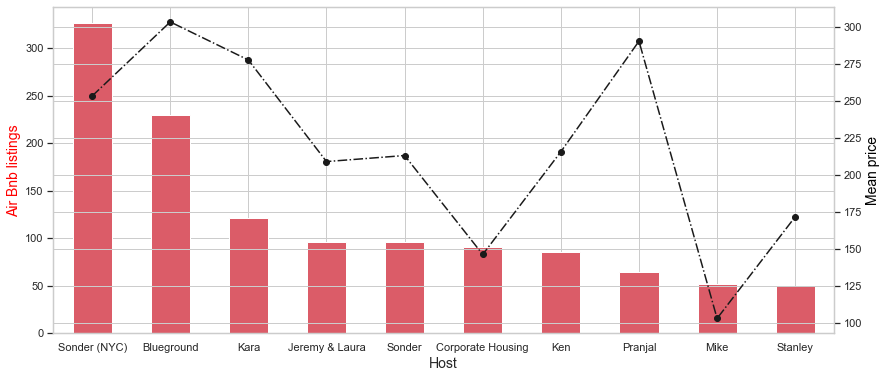

In [21]:
fig, ax = plt.subplots(figsize=(14,6))

top_host_df['host_id'].plot(kind = 'bar', ax = ax, rot = 0, color=colors[3])
ax.set_xlabel('Host', fontsize=14)
ax.set_ylabel('Air Bnb listings', color = 'red', fontsize=14)
ax2=ax.twinx()
ax2.plot(top_host_df['mean_price'], 'ko-.')
ax2.set_ylabel("Mean price",color="black", fontsize=14)
plt.show()

If you are looking for a cheaper place to stay, listings by Mike might be a good place to stay. For luxury, look to Blueground or Pranjal.

Now we will take a quick look at the other data sets which we would like to include in order for us to choose the optimal AirBnb. The data sets contain crime incidents, noise complaints and cafes/restaurants. From our travel experiences, these attributes can have a significant effect on the holiday. We also suspect that it can have an effect on the price of an AirBnb. 

Below we load in the data sets can pass them neighborhood names as the original ones did not have that attribute. These neighborhood names differ slightly from the ones in the AirBnb data set. Apparently, partioning Manhattan into neighborhoods can be done in many ways and there is no clear number of neighborhoods. The shp-file including neighborhoods that we found contains fewer neighborhoods than in the AirBnb data set. To cope with this we merge some neighborhoods into one to get a total of 20 neighborhoods instead of 32.

In [26]:
neighborhood_names = list(nil['NTAName'])
neighborhoods = ['washingtonheights', 'uppereastside', 'upperwestside', 'eastharlem', 'harlem', 'midtown', 'hellskitchen',
                'financial', 'morningheights', 'chelsea', 'westvillage', 'eastvillage', 'lowereast', 'murrayhill',
                'morningheights', 'rooseveltisland', 'soho', 'chinatown', 'gramercy', 'stuyvesant']
num_cafe = []
num_crime = []
num_noise = []
cafes_df = pd.DataFrame()
crimes_df = pd.DataFrame()
noise_df = pd.DataFrame()
for i in range(len(neighborhoods)):
    place = neighborhoods[i]
    nca = pd.read_csv('crime/cafes_' + str(place) + '.csv', encoding= 'unicode_escape')
    ncr = pd.read_csv('crime/crimes_' + place + '.csv')
    nno = pd.read_csv('crime/noise_' + place + '.csv')
    nca['neighbourhood'] = neighborhood_names[i]
    ncr['neighbourhood'] = neighborhood_names[i]
    nno['neighbourhood'] = neighborhood_names[i]
    
    cafes_df = cafes_df.append(nca)
    crimes_df = crimes_df.append(ncr)
    noise_df = noise_df.append(nno)
    
    num_cafe.append(len(nca))
    num_crime.append(len(ncr))
    num_noise.append(len(nno))

FileNotFoundError: [Errno 2] No such file or directory: 'crime/cafes_washingtonheights.csv'

Below we show how many cafes/restaurants, crime incidents and noise complaints there are across the neighbourhoods.

In [25]:
df_manhattan_cafe = cafes_df.groupby('neighbourhood').count()
df_manhattan_crime = crimes_df.groupby('neighbourhood').count()
df_manhattan_noise = noise_df.groupby('neighbourhood').count()

KeyError: 'neighbourhood'

In [ ]:
df_manhattan_crime

In [ ]:
# fig, ax = plt.subplots(3,1,figsize=(14,20), sharex=True)
# (df_manhattan_cafe['field_1']).plot(kind = 'bar', ax = ax[0], rot = 90, color = colors[3])
# ax[0].set_ylabel('No. of cafes/restaurants')
# (df_manhattan_crime['field_1']).plot(kind = 'bar', ax = ax[1], rot = 70, color = colors[4])
# ax[1].set_ylabel('No. of crimes')
# (df_manhattan_noise['Incident Zip']).plot(kind = 'bar', ax = ax[2], rot = 90, color = colors[5])
# ax[2].set_ylabel('No. of noise complaints')
# plt.show()
fig, ax = plt.subplots(3,1,figsize=(14,20), sharex=True)
(df_manhattan_cafe['CAMIS']/nil['Shape_Area'].values*1e5).plot(kind = 'bar', ax = ax[0], rot = 90, color = colors[3])
ax[0].set_ylabel('No. of cafes/restaurants')
(df_manhattan_crime['field_1']/nil['Shape_Area'].values*1e5).plot(kind = 'bar', ax = ax[1], rot = 70, color = colors[4])
ax[1].set_ylabel('No. of crimes')
(df_manhattan_noise['Incident Zip']/nil['Shape_Area'].values*1e5).plot(kind = 'bar', ax = ax[2], rot = 90, color = colors[5])
ax[2].set_ylabel('No. of noise complaints')
plt.show()

Midtown and Theater District share a great amount of cafes and restaurants while Stuvesant Town, Financial District and Battery Park City have very few according to our data set. Harlem and Washington Heights peak in both crime and noise complaints making it a perfect place for the adventures. East Village seems like a good place for the traveller who likes going out to eat, but doesn't fancy getting robbed in the process. This is in accordance with what we can find of information on the neighborhoods. No noise complaints were filed in Stuyvesant Town (!), hence it could be an ideal neighborhood if one appreciates silence

We can gather some of the key information obtained from the analysis above in a spatial map partioned by neighborhood in chloropath-style. To this end, we use the folium-package to display the shp-file with the neighborhoods in a open street view map. We have added the key characteristics to the shp-file. Hover over the neighborhoods to reveal some key characteristics!

In [30]:
## Creating basemap with the color grading dependent on price
mymap = folium.Map(location=[40.7788, -73.9660], zoom_start=12,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)
myscale = (nil['Avg_Price'].quantile((0,0.15,0.30,0.45,0.60,0.85, 1))).tolist()
mymap.choropleth(
 geo_data=nil,
 name='Choropleth',
 data=nil,
 columns=['NTAName','Avg_Price'],
 key_on="feature.properties.NTAName",
 fill_color='YlGnBu',
 threshold_scale=myscale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='Average rent price pr. night [$]',
 smooth_factor=0
)
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

In [34]:
## Adding the pop-up
NIL = folium.features.GeoJson(
    nil,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NTAName','Avg_Price', 'Density', 'crime_day', 'noise_dens', 'cafe_dens'],
        aliases=['Neighborhood: ','Average price pr. night [$]: ', 'Air bnb pr. km2: ', 'Crime incident pr. year pr. km2: ',
                'Noise complaints pr. km2: ', 'Cafes pr. km2: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
#mymap.add_child(NIL)
#mymap.keep_in_front(NIL)
#folium.LayerControl().add_to(mymap)
mymap

#mymap.save("mymap.html")

The values can be a bit confusing as we have divided by the area of the neighborhood, but we deemed it more saying when it is given relative to size. It is clear that the more expensive neighborhoods are found South of Central Park. It appears that there are quite a few cheap options around Roosevelt Island, Washington Heights, Marble Hill an Inwood.

In [ ]:
df_manhattan_size = df_manhattan.groupby(['neighbourhood', 'room_type']).count()

In [ ]:
neigh_type = ['Battery Park City', 'Chelsea', 'Chinatown', 'Civic Center', 'East Harlem',
 'East Village', 'Financial District', 'Flatiron District','Gramercy',
 'Greenwich Village', 'Harlem', "Hell's Kitchen", 'Inwood', 'Kips Bay',
 'Little Italy', 'Lower East Side', 'Marble Hill', 'Midtown',
 'Morningside Heights', 'Murray Hill', 'NoHo', 'Nolita', 'Roosevelt Island',
 'SoHo', 'Stuyvesant Town', 'Theater District', 'Tribeca', 'Two Bridges',
 'Upper East Side', 'Upper West Side', 'Washington Heights', 'West Village']

norm_df = df_manhattan_size.copy()
for i in neigh_type:
    tot = df_manhattan_size.loc[i].sum()[0]
    norm_df.loc[i] = (norm_df.loc[i].values)/tot




In [ ]:
norm_df = norm_df.reset_index()
norm_df = norm_df.set_index('neighbourhood')

In [ ]:

df_hoods = df_manhattan[['id', 'neighbourhood', 'room_type']]
table = pd.pivot_table(df_hoods, index = ['neighbourhood'], columns = 'room_type',  aggfunc = 'count', fill_value = 0)
table

In [ ]:
bar_width = 0.2
fig, ax = plt.subplots(figsize=(22,8))
x = np.arange(len(norm_df.index.unique()))
x_alt = np.arange(len(norm_df.loc[norm_df['room_type'] == 'Shared room'].index.unique()))

b1 = ax.bar(x, norm_df.loc[norm_df['room_type'] == 'Entire home/apt'].id, width=bar_width)
b2 = ax.bar(x+bar_width, norm_df.loc[norm_df['room_type'] == 'Private room'].id, width=bar_width)
#b3 = ax.bar(x_alt+bar_width, norm_df.loc[norm_df['room_type'] == 'Shared room'].id, width=bar_width)

ax.set_xticks(x + bar_width/5)
ax.set_xticklabels(norm_df.index.unique(), rotation = 90)
plt.show()

In [ ]:
#bar_width = 0.2
fig, ax = plt.subplots(figsize=(16,8))
x = np.arange(len(norm_df.index.unique()))
b1 = ax.bar(list(norm_df.index.unique()), norm_df.loc[norm_df['room_type'] == 'Entire home/apt'].id)
b2 = ax.bar(list(norm_df.index.unique()), norm_df.loc[norm_df['room_type'] == 'Private room'].id)
b3 = ax.bar(list(norm_df.loc[norm_df['room_type'] == 'Shared room'].index.unique()), norm_df.loc[norm_df['room_type'] == 'Shared room'].id)
ax.set_xticklabels(list(norm_df.index.unique()), rotation = 90)
plt.show()

In [ ]:
norm_df.head(10)

In [ ]:
### Spatial analysis
#count_bnb = count_bnb.reset_index()
## Extracting coordinates
lats = list(df_manhattan.latitude)
lons = list(df_manhattan.longitude)

## Handling data format
coord_list = []
for i in range(len(lats)):
    coord_list.append([lats[i], lons[i]])
bnb_map = folium.Map([40.7388, -74.0060], zoom_start=12.5, tiles = 'Stamen Toner')
HeatMap(coord_list, radius = 14, max_zoom = 13).add_to(bnb_map)
bnb_map

In [ ]:
dot_map = folium.Map([40.7388, -74.0060], zoom_start=12, tiles = 'Stamen Toner')
for lat, lon in zip(df_manhattan['latitude'], df_manhattan['longitude']):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color='red',
        fill = False,
        ).add_to(dot_map)
dot_map


In [ ]:
df_manhattan_avgprice = df_manhattan.groupby(['room_type', 'neighbourhood']).mean()

#(df_manhattan_price.sort_values(by = 'price', ascending = False))['price'].plot(kind = 'bar', ax = ax, rot = 60)
fig, ax = plt.subplots(2,1, figsize=(16,14), sharex= True)
((df_manhattan_avgprice.sort_values(by ='price', ascending = False)).loc['Entire home/apt'].price).plot(kind = 'bar', ax=ax[0], title = 'Entire home', color = 'red')
((df_manhattan_avgprice.sort_values(by ='price', ascending = False)).loc['Private room'].price).plot(kind = 'bar', ax=ax[1], title = 'Private room', color = 'green')
#((df_manhattan_avgprice.sort_values(by ='price', ascending = False)).loc['Shared room'].price).plot(kind = 'bar', ax=ax[2], title = 'Shared room', color = 'blue')
plt.tight_layout(h_pad=1.2)


In [ ]:
#(df_manhattan_price.sort_values(by = 'price', ascending = False))['price'].plot(kind = 'bar', ax = ax, rot = 60)
fig, ax = plt.subplots(2,1, figsize=(16,14), sharex= True)
(df_manhattan_avgprice.loc['Entire home/apt'].price).plot(kind = 'bar', ax=ax[0], title = 'Entire home', color = 'red')
(df_manhattan_avgprice.loc['Private room'].price).plot(kind = 'bar', ax=ax[1], title = 'Private room', color = 'green')
#((df_manhattan_avgprice.sort_values(by ='price', ascending = False)).loc['Shared room'].price).plot(kind = 'bar', ax=ax[2], title = 'Shared room', color = 'blue')
plt.tight_layout(h_pad=1.2)


In [ ]:
### Distribution analysis
most_listings = ['Harlem', 'Upper West Side', 'Hell\'s Kitchen', 'East Village', 'Upper East Side', 'Chelsea', 'West Village', 'Midtown']
df_small = df_manhattan[df_manhattan.neighbourhood.isin(most_listings)]




In [ ]:
fig, axes = plt.subplots(figsize=(14, 8))
v2=sns.violinplot(ax = axes, data=df_small[df_small.price < 500], x='neighbourhood', y='price')
v2.set_title('Density and distribution of prices for each neighberhood_group')

In [ ]:
fig, axes = plt.subplots(figsize=(14, 8))
b2 = sns.boxplot(ax = axes, data = df_small[df_small.price <= 1000], x="neighbourhood", y="price")

In [ ]:
df_small

In [ ]:
### Investegating availability
fig, axes = plt.subplots(figsize=(14, 8))
v2=sns.violinplot(ax = axes, data=df_small, x='neighbourhood', y='availability_365')
v2.set_title('Density and distribution of prices for each neighberhood_group')

In [ ]:
### Making new column with merged districts
merged_df = df_manhattan.copy()
merged_df['district'] = merged_df['neighbourhood']


In [ ]:
merged_df['district'] = ['FinancialDistrict_BatteryParkCity' if x == 'Financial District' or x == 'Battery Park City' else x for x in merged_df['district']]
merged_df['district'] = ['SoHo_Tribeca_CivicCenter_LittleItaly_Nolita' if x == 'SoHo' or x == 'Tribeca' or x == 'Civic Center' or x == 'Little Italy' or x == 'Nolita' else x for x in merged_df['district']]
merged_df['district'] = ['Chelsea_Flatiron' if x == 'Chelsea' or x == 'Flatiron District' else x for x in merged_df['district']]
merged_df['district'] = ['MurrayHill_KipsBay' if x == 'Murray Hill' or x == 'Kips Bay' else x for x in merged_df['district']]
merged_df['district'] = ['MarbleHill_Inwood' if x == 'Marble Hill' or x == 'Inwood' else x for x in merged_df['district']]
merged_df['district'] = ['Midtown_TheaterDistrict' if x == 'Midtown' or x == 'Theater District' else x for x in merged_df['district']]
merged_df['district'] = ['WestVillage_GreenVillage_NoHo' if x == 'West Village' or x == 'Greenwich Village' or x == 'NoHo' else x for x in merged_df['district']]
merged_df['district'] = ['Chinatown_TwoBridges' if x == 'Chinatown' or x == 'Two Bridges' else x for x in merged_df['district']]

In [ ]:
## Calculating relevant features (more will come)
merged_count = (merged_df.groupby('district').count()).id.values
merged_avgprice = (merged_df.groupby('district').mean()).price.values
dist_area = dist_df.sort_values('NTAName')['area'].values*10e4
dist_dense = merged_count/dist_area
crime_dense = num_crime/dist_area
cafe_dense = num_cafe/dist_area
noise_dense = num_noise/dist_area

In [ ]:
#print('cafes: ', cafe_dense)
#print('crimes: ', crime_dense) 
print('noise: ', noise_dense)


In [ ]:
#### import geopandas as gpd
fname = 'manhat_last.shp'
nil = gpd.read_file(fname)
list(nil['NTAName'])

In [ ]:
### Map with no pop-up
mymap = folium.Map(location=[40.7788, -73.9660], zoom_start=12,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)
myscale = (nil['Avg_Price'].quantile((0,0.15,0.30,0.45,0.60,0.85, 1))).tolist()
mymap.choropleth(
 geo_data=nil,
 name='Choropleth',
 data=nil,
 columns=['NTAName','Avg_Price'],
 key_on="feature.properties.NTAName",
 fill_color='YlGnBu',
 threshold_scale=myscale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='Average rent price%',
 smooth_factor=0
)
mymap

In [ ]:
### Map with popups
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    nil,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NTAName','Avg_Price', 'Density', 'crime_day', 'noise_dens', 'cafe_dens'],
        aliases=['Neighborhood: ','Average price pr. night [$]: ', 'Air bnb pr. km2: ', 'Crime incident pr. year pr. km2: ',
                'Noise complaints pr. km2: ', 'Cafes pr. km2: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
mymap.add_child(NIL)
mymap.keep_in_front(NIL)
folium.LayerControl().add_to(mymap)
mymap

In [ ]:
df_crime['OFNS_DESC'].unique()
crimes_to_keep = ['GRAND LARCENY', 'FELONY ASSAULT', 'SEX CRIMES', 'PETIT LARCENY', 'BURGLARY', 'ROBBERY',  'RAPE',
                 'DISORDERLY CONDUCT', 'DANGEROUS DRUGS', 'DANGEROUS WEAPONS', 'ASSAULT 3 & RELATED OFFENSES', 'KIDNAPPING',
                  'UNDER THE INFLUENCE OF DRUGS','INTOXICATED/IMPAIRED DRIVING', 'PROSTITUTION & RELATED OFFENSES']

crimes_to_keep_alt = ['PETIT LARCENY', 'GRAND LARCENY', 'HARRASSMENT 2',
       'ASSAULT 3 & RELATED OFFENSES', 'CRIMINAL MISCHIEF & RELATED OF',
       'DANGEROUS DRUGS', 'OFF. AGNST PUB ORD SENSBLTY &', 'ROBBERY',
       'FELONY ASSAULT', 'BURGLARY', 'OFFENSES AGAINST PUBLIC ADMINI',
       'DANGEROUS WEAPONS', 'MISCELLANEOUS PENAL LAW', 'CRIMINAL TRESPASS',
       'THEFT-FRAUD', 'FORGERY', 'SEX CRIMES',
       'INTOXICATED & IMPAIRED DRIVING', 'VEHICLE AND TRAFFIC LAWS',
       'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']

df_crime = df_crime.set_index('OFNS_DESC')
df_crime = df_crime.loc[crimes_to_keep_alt]

In [ ]:
## Investigating crimes 
#df_crime = df_crime.reset_index(drop = False)
count_crimes = df_crime.groupby('OFNS_DESC').count()
fig, ax = plt.subplots(figsize = (14,4))
(count_crimes['CMPLNT_NUM'].sort_values(0, False)).plot(kind = 'bar')
